| **Name**         | Tufan Kundu               |
|------------------|---------------------------|
| **Reg No.**      | 24MDT0184                 |
| **Course Name**  | Financial Analytics Lab   |
| **Course Code**  | PMDS610P                  |
| **Assessment**   | Lab Digital Assessment 2  |


# Problem Statement
You are given historical daily closing prices of the NIFTY 50 index from  the National Stock Exchange of India (NSE). Your task is to analyze and  forecast stock prices using an AutoRegressive Moving Average (ARMA) model.

[*********************100%***********************]  1 of 1 completed


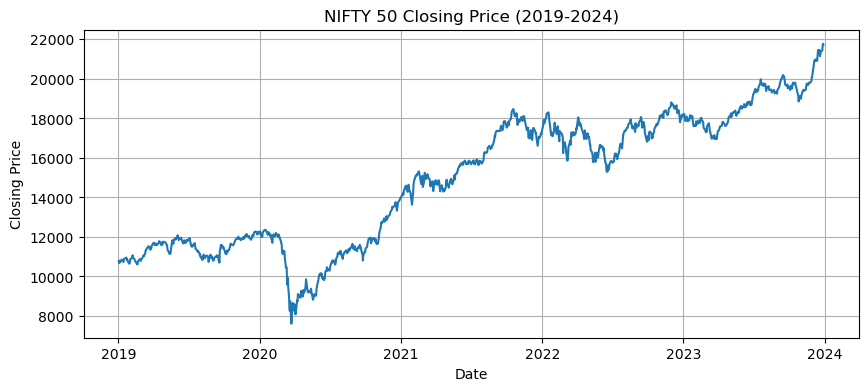

ADF Statistic: -0.1888
p-value: 0.9398
Series is non-stationary. Applying first-order differencing...
ADF Statistic: -12.2918
p-value: 0.0000


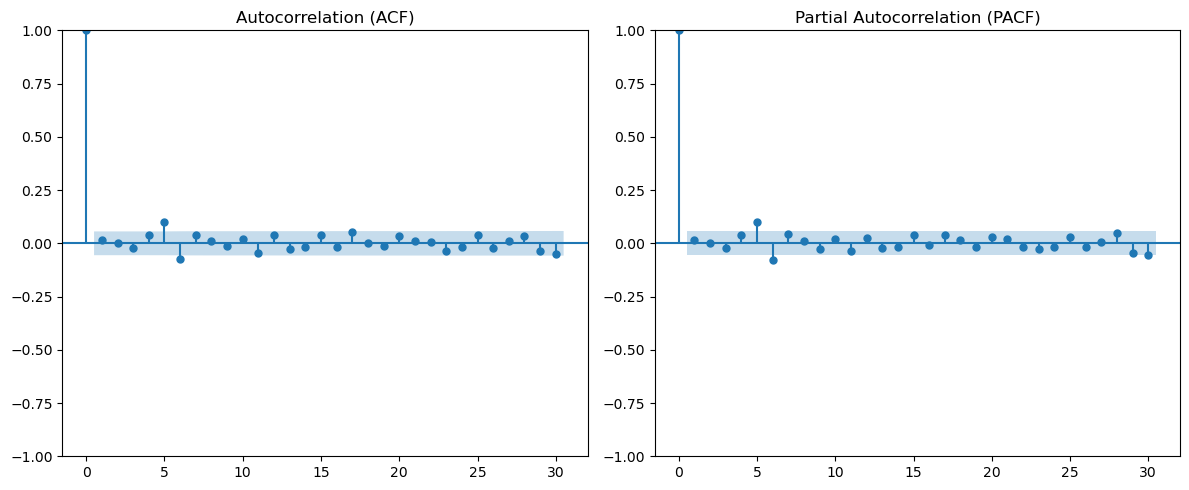


📈 Model Evaluation:
Mean Squared Error (MSE): 13546.87
Mean Absolute Percentage Error (MAPE): 129.60%


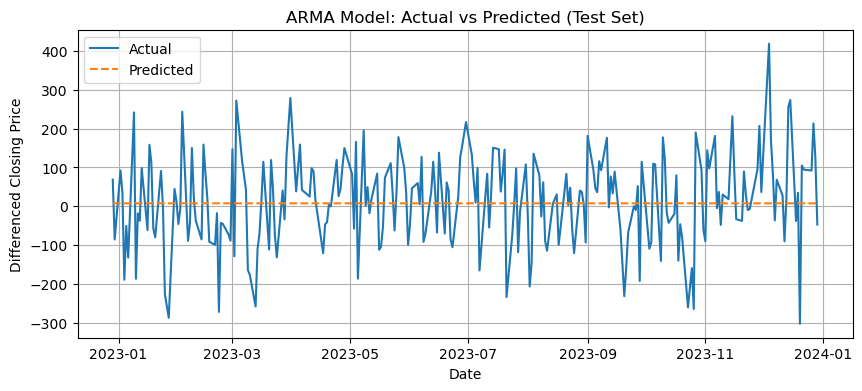


Forecasted NIFTY 50 Closing Prices (Next 30 Business Days):
            Forecasted_Close_Price
Date                              
2024-01-01                21739.40
2024-01-02                21748.32
2024-01-03                21757.21
2024-01-04                21766.09
2024-01-05                21774.98
2024-01-08                21783.86
2024-01-09                21792.75
2024-01-10                21801.64
2024-01-11                21810.52
2024-01-12                21819.41
2024-01-15                21828.30
2024-01-16                21837.18
2024-01-17                21846.07
2024-01-18                21854.95
2024-01-19                21863.84
2024-01-22                21872.73
2024-01-23                21881.61
2024-01-24                21890.50
2024-01-25                21899.39
2024-01-26                21908.27
2024-01-29                21917.16
2024-01-30                21926.04
2024-01-31                21934.93
2024-02-01                21943.82
2024-02-02                219

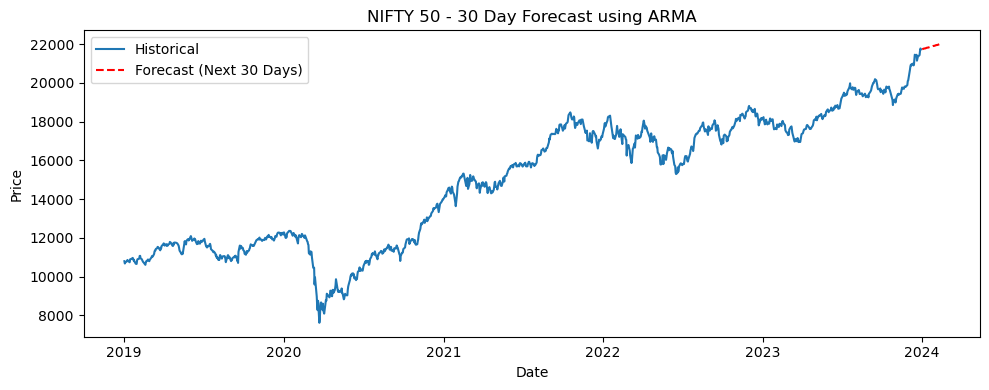

In [3]:
# -----------------------------------------------
#  1. Importing Required Libraries
# -----------------------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings 
warnings.filterwarnings('ignore')

# -----------------------------------------------
#  2. Loading and Preprocessing Data
# -----------------------------------------------
data = yf.download("^NSEI", start="2019-01-01", end="2024-01-01")
nifty = data[['Close']].copy()
nifty.dropna(inplace=True)
nifty.index = pd.to_datetime(nifty.index)

# Plotting original data
plt.figure(figsize=(10, 4))
plt.plot(nifty['Close'])
plt.title("NIFTY 50 Closing Price (2019-2024)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

# -----------------------------------------------
#  3. Stationarity Check
# -----------------------------------------------
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    return result[1]

p_val = adf_test(nifty['Close'])

if p_val > 0.05:
    print("Series is non-stationary. Applying first-order differencing...")
    nifty_diff = nifty['Close'].diff().dropna()
    adf_test(nifty_diff)
else:
    print("Series is stationary.")
    nifty_diff = nifty['Close']

# -----------------------------------------------
# 4. ACF and PACF for ARMA (p, q)
# -----------------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(nifty_diff, lags=30, ax=plt.gca())
plt.title("Autocorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(nifty_diff, lags=30, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

# Choosing ARMA(1,1)
p, q = 1, 1

# -----------------------------------------------
# 5. Training ARMA Model
# -----------------------------------------------
train_size = int(len(nifty_diff) * 0.8)
train, test = nifty_diff[:train_size], nifty_diff[train_size:]

model = ARIMA(train, order=(p, 0, q)).fit()

# Predicting using index locations
start = len(train)
end = start + len(test) - 1
preds = model.predict(start=start, end=end)
preds.index = test.index

# -----------------------------------------------
# 6. Evaluating Performance
# -----------------------------------------------
mse = mean_squared_error(test, preds)
mape = mean_absolute_percentage_error(test, preds)
print(f"\n📈 Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

plt.figure(figsize=(10, 4))
plt.plot(test, label="Actual")
plt.plot(preds, label="Predicted", linestyle='--')
plt.title("ARMA Model: Actual vs Predicted (Test Set)")
plt.xlabel("Date")
plt.ylabel("Differenced Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------
# 7. Forecasting Next 30 Days
# -----------------------------------------------
final_model = ARIMA(nifty_diff, order=(p, 0, q)).fit()
forecast_diff = final_model.forecast(steps=30)

# Ensure last_actual is a scalar
last_actual = nifty['Close'].iloc[-1].item()  

# Converting to NumPy array
forecast_diff_np = forecast_diff.to_numpy()

# Forecast = cumulative sum of forecasted differences + last known actual value
forecast = np.cumsum(forecast_diff_np) + last_actual

# Generate dates
forecast_dates = pd.date_range(start=nifty.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# -----------------------------------------------
# 8. Display Forecasted Values
# -----------------------------------------------
# Creating a DataFrame with forecasted dates and values
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecasted_Close_Price": forecast
})

# Setting 'Date' as the index for neat display
forecast_df.set_index("Date", inplace=True)

# Displaying the forecast table
print("\nForecasted NIFTY 50 Closing Prices (Next 30 Business Days):")
print(forecast_df.round(2))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(nifty['Close'], label="Historical")
plt.plot(forecast_dates, forecast, label="Forecast (Next 30 Days)", linestyle="--",color = 'red')
plt.title("NIFTY 50 - 30 Day Forecast using ARMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

